# Channel Model

This notebook is used to create Channel Model for mmWave base on extended Saleh-Valenzuela model, which allows us to accurately capture the mathematical structure present in mmWave channels.
Most content is base on the paper:

O. El Ayach, S. Rajagopal, S. Abu-Surra, Z. Pi, and R. Heath, “Spatially sparse precoding in millimeter wave MIMO systems,” IEEE Transactions on WirelessCommunications, vol. 13, no. 3, pp. 1499–1513, March 2014

and Matlab Sourcode from repository https://github.com/xyuam/Alternating-minimization-algorithms-for-hybrid-precoding-in-millimeter-wave-MIMO-systems

$$H = \sqrt{\frac{N_{t}N_{r}}{N_{cl}N_{ray}}}\sum_{i=1}^{N_{cl}}\sum_{l=1}^{N_{ray}}\alpha_{il}\mathbf{a_{r}}(\phi _{il}^{r},\theta _{il}^{r} )\mathbf{a_{t}}(\phi _{il}^{t},\theta _{il}^{t} )^{H}$$

Where $N_{cl}$ and $N_{ray}$ represent the number of clusters and the number of rays in each cluster, and $\alpha_{il}$ denotes the gain of the $l^{th}$ ray in the $i^{th}$ propagation cluster. We assume that $\alpha_{il}$ are i.i.d and follow the distribution $\mathcal{C}\mathcal{N}(0,\sigma _{\alpha ,i}^{2})$ and $\sum _{i=1}^{N_{cl}}\sigma _{\alpha ,i}^{2} = \hat{\gamma }$, which is the normalization factor to satisfy $\mathbf{E}\left [ \left \| \mathbf{H} \right \|_{F}^{2}\right ] = N_{t}N_{r}$. In addition $\mathbf{a_{r}}(\phi _{il}^{r},\theta _{il}^{r} )$ and $\mathbf{a_{t}}(\phi _{il}^{t},\theta _{il}^{t} )$ represent the receive and transmit array response vectors, where $\phi _{il}^{r}$($\phi _{il}^{t}$) and $\theta _{il}^{r}$($\theta _{il}^{t}$) stand for azimuth and elevation angles of arrival and departure, respectively. We use the uniform square planar array (USPA) with $\sqrt{N}$x$\sqrt{N}$ antenna elements.

In [1]:
# import necessary module 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
steeringvector = io.loadmat('steeringvector_2.mat')


In [18]:
AoD_matrix = steeringvector['AoD_matrix'] + 1j*0
AoA_matrix = steeringvector['AoA_matrix'] + 1j*0
alpha = steeringvector['alpha'] 
H_matlab = steeringvector['H'] 
Fopt_matlab = steeringvector['Fopt']
Wopt_matlab = steeringvector['Wopt'] 

In [3]:
steeringvector

{'AoA_matrix': array([[[ 2.31121383,  0.97148301,  0.37951546, ...,  0.28522158,
           2.59276493,  3.3082232 ],
         [ 2.25096735,  0.75135728,  0.11821006, ...,  0.9022028 ,
           2.862533  ,  3.25940709],
         [ 2.39422394,  0.94797197,  0.36270414, ...,  0.54535963,
           2.58637211,  3.20515753],
         ..., 
         [ 3.58319588,  3.72615147,  0.45861313, ...,  2.35999441,
           0.46904974,  2.87272642],
         [ 3.27199346,  4.08604908,  1.17296529, ...,  2.3189071 ,
           0.7090424 ,  2.75498422],
         [ 3.33231231,  3.94154196,  0.99792342, ...,  2.31251787,
           0.4510016 ,  2.8109667 ]],
 
        [[ 2.05886281,  1.1016383 ,  1.05913977, ...,  6.22526053,
           0.83344234,  1.02601047],
         [ 1.85439658,  1.26237106,  1.35343623, ...,  5.85505681,
           1.0196464 ,  1.06465825],
         [ 1.78046655,  1.48316043,  1.50001984, ...,  5.83508481,
           0.55998286,  1.05752086],
         ..., 
         [ 4.6624

### Array Response

This function is used to calculate the array response in uniform square planar array (USPA) with given azimuth, elevation angle and number of element
$$\mathbf{a}(\phi _{il},\theta _{il}) = \frac{1}{\sqrt{N}}[1,...,e^{j\frac{2\pi }{\lambda}d(psin\phi _{il}sin\theta _{il}+qcos\theta _{il})},...,e^{j\frac{2\pi }{\lambda}d((\sqrt{N}-1)sin\phi _{il}sin\theta _{il}+(\sqrt{N}-1)cos\theta _{il})}]^{T}$$

In [4]:
def array_response(a1,a2,N):
    y = np.zeros((N,1),dtype=complex)
    for m in range(int(np.sqrt(N))):
        for n in range(int(np.sqrt(N))):
            y[m*(int(np.sqrt(N)))+n] = np.exp(1j*np.pi*(m*np.sin(a1)*np.sin(a2) + n*np.cos(a2)))
    y = y/np.sqrt(N)
    y = np.ravel(y) # Convent to 1-dimention, MAY BE NOT THE BEST WAY
    return y

In [5]:
test = array_response(AoD_matrix[0,0,0],AoD_matrix[0,1,0],4) # Test output of array response
print(test)

[ 0.50000000+0.j         -0.49425097-0.07560412j  0.47577741+0.15373956j
 -0.44706020-0.22391332j]


### Parameters declaration

Declare parameters needed for channel realization

In [6]:
Ns = 3 # number of streams

Nc = 5 # number of cluster
Nray = 10 # number of rays in each cluster

Nt = 144 # number of transmit antennas
Nr = 36 # number of receive antennas

angle_sigma = 10/180*np.pi # standard deviation of the angles in azimuth and elevation both of Rx and Tx

gamma = np.sqrt((Nt*Nr)/(Nc*Nray))
sigma = 1 # according to the normalization condition of H

realization = 1000 # equivalent to number of taking sample
count = 0


In [7]:
print(angle_sigma)

0.17453292519943295


### Example of Laplacian Distribution
Using Laplacian distributed for declaration of azimuth and elevation angles of arrival and departure (has been found to be a good fit for a variaty of propagation scenarios)

array([[-2.05822042,  0.72048906,  0.14775091],
       [-0.49961295,  0.44227408, -0.02614177]])

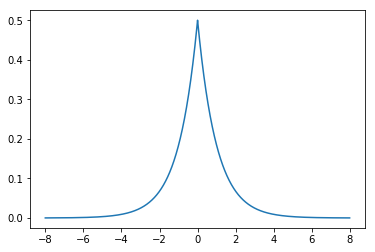

In [8]:
# plot the probability density function (PDF) of Laplacian Distribution
loc, scale = 0., 1.
s = np.random.laplace(loc, scale, 1000)
# count, bins, ignored = plt.hist(s, 30, normed=True)
x = np.arange(-8., 8., .01)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
plt.plot(x, pdf)
# example of create matrix of laplacian variables
y = np.random.laplace(loc, scale, (2,3))
y

### Channel Realization

Create Channel Matrix H and also the optimal Precoder and Combiner (Fopt and Wopt) for MIMO system

In [9]:
H = np.zeros((Nr,Nt,realization),dtype=complex)
At = np.zeros((Nt,Nc*Nray,realization),dtype=complex)
Ar = np.zeros((Nr,Nc*Nray,realization),dtype=complex)
Fopt = np.zeros((Nt,Ns,realization),dtype=complex)
Wopt = np.zeros((Nr,Ns,realization),dtype=complex)

AoD = np.zeros((2,Nc*Nray),dtype=complex)
AoA = np.zeros((2,Nc*Nray),dtype=complex)

for reali in range(realization):
    AoD = AoD_matrix[:,:,reali]
    AoA = AoA_matrix[:,:,reali]
    
    for j in range(Nc*Nray):
        At[:,j,reali] = array_response(AoD[0,j],AoD[1,j],Nt) # UPA array response
        Ar[:,j,reali] = array_response(AoA[0,j],AoA[1,j],Nr)
        H[:,:,reali] = H[:,:,reali] + alpha[j,reali]*Ar[:,[j],reali]@At[:,[j],reali].conj().T
    H[:,:,reali] = gamma * H[:,:,reali]
    if (np.linalg.matrix_rank(H[:,:,reali])>=Ns):
        count = count + 1
        U, s, V = np.linalg.svd(H[:,:,reali], full_matrices=True)
        Fopt[:,:,reali] = V[0:Nt,0:Ns]
        Wopt[:,:,reali] = U[0:Nr,0:Ns]

In [10]:
print(H[:,0,0])

[ 0.17051364-0.20507655j  0.58112628-1.30207465j  0.61677456-1.63265148j
  0.15237734+0.30933742j -1.00905940-1.04661916j  0.76296983+0.14134202j
 -0.16379400+0.28492533j  2.22674986+0.08825693j  0.95306112+0.81358351j
  0.04123477+0.14015698j  0.09161558-1.29826087j  0.56478031+0.25584725j
 -0.52083595+0.22410843j  0.82316897+1.61855229j -1.50900509+0.84055355j
  0.26900471-0.92702236j  1.09658129-0.07920158j  0.37337196+0.16580461j
 -0.53608390+0.44429395j -0.48283792+0.53359361j -0.55157115-1.10331086j
  2.01669872-0.32542049j  0.13602250+1.65235837j  0.09841299-0.32745594j
 -1.03999737+0.24218184j -0.20892857-0.27159661j  0.75676231+0.68920805j
  0.70296233+1.79379887j -1.59856088+0.78669949j  0.94662125-0.97341119j
 -0.51206611-0.25318454j -0.20799193-0.6346923j  -1.16336940+1.12819295j
 -1.52508574+0.24379706j -0.52451473-0.38941923j  1.79260756+0.69060821j]


In [11]:
print(H.shape)
print(Ar.shape)
print(At.shape)
print(Fopt.shape)
print(Wopt.shape)

(36, 144, 1000)
(36, 50, 1000)
(144, 50, 1000)
(144, 3, 1000)
(36, 3, 1000)


**Store Variables to reuse**

In [12]:
# %store Ns
# %store Nt
# %store Nr
# %store Nc
# %store Nray

# %store H
# %store Fopt
# %store Wopt
# %store realization
# %store At
# %store Ar

In [13]:
# print(H.shape)
# plt.plot(Wopt[:,2,1].real)
# np.absolute(1.2 + 1j)
# a = np.array([1+2j, 3+4j, 5+6j])
# a.imag


In [30]:
print(H[1,1,1])
print(H_matlab[1,1,1])
np.all(np.isclose(Wopt,Wopt_matlab))

(0.167026098371-0.18396143915j)
(0.167026098371-0.18396143915j)


True

In [14]:
var = {}
var['H']=H
var['Wopt']=Wopt
var['Fopt']=Fopt
var['Ns']=[[Ns]]
var['Nt']=[[Nt]]
var['Nr']=[[Nr]]
var['Nc']=[[Nc]]
var['Nray']=[[Nray]]
var['realization']=[[realization]]
var['At']=At
var['Ar']=Ar

io.savemat('temp',var)
